In [240]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import random
import matplotlib.cm as cm
import time
sn.set()

# uncomment if first time use
# !pip install mxnet-cu101 --target=$nb_path 

import mxnet as mx
from mxnet.gluon import nn, loss as gloss, rnn
from mxnet.gluon import data as gdata
from mxnet import gluon
from mxnet import nd,init
from mxnet.contrib import text
from mxnet import autograd

In [241]:
def generate_data(size = 9000, disturb_prob = 0):
    X1 = np.zeros(size)
    X2 = np.zeros(size)
    Y = np.zeros(size)
    
    ssize = size // 9
    for i in range(3):
        for j in range(3):
            s = slice((3*i+j)*ssize, (3*i+j+1)*ssize)
            X1[s] = np.random.rand(ssize) + j
            X2[s] = np.random.rand(ssize) + i
            Y[s] = 3*i+j
    if disturb_prob != 0:
        Y = disturb(Y, prob = disturb_prob)
    X = np.concatenate([X1.reshape(-1,1), X2.reshape(-1,1)], axis = 1)
    return X,Y

def disturb(Y, prob = 0.5):
    """prob: prob for noise generation"""
    probs = np.random.rand(len(Y))
    random_labels = np.random.randint(0, 9, size=len(Y))
    return np.array([random_label if p < prob else y for y, p, random_label in zip(Y, probs, random_labels)])

In [248]:
def LR(out_dim):
    net = nn.Sequential()
    net.add(nn.Dense(out_dim))
    net.initialize(init.Xavier())
    return net

def evaluate(net, iter):
    corr, n = 0, 0
    for batch in iter:
        X, y = batch
        out = net(X)
        corr += nd.sum(out.argmax(axis=1) == y.astype('float32')).asscalar() 
        n += y.size
    return corr/ n

def train(net, train_iter, test_iter, trainer, loss, num_epoch = 100, verbose=True):
    train_acc, test_acc = [evaluate(net, train_iter)], [evaluate(net, test_iter)]
    print("Before training, train acc: %.3f, test acc: %.3f"                   
          % (train_acc[-1], test_acc[-1]))
    for i in range(num_epoch):
        start = time.time()
        for batch in train_iter:
            X, y = batch
            with autograd.record():
                output = net(X)
                l_sum = loss(output, y)
            l_sum.backward()
            trainer.update(len(y))
        train_acc.append(evaluate(net, train_iter))
        test_acc.append(evaluate(net, test_iter))
        if verbose and (i+1)%5 == 0:
            print("epoch %d, train acc: %.3f, test acc: %.3f, time: %.3f" 
                  % (i+1, train_acc[-1], test_acc[-1], time.time() - start))
    plot_conv_line(train_acc, test_acc)
    return (train_acc, test_acc)

def plot_conv_line(train_acc, test_acc):
    x = np.arange(len(train_acc))
    plt.plot(x, train_acc, label='train_acc')
    plt.plot(x, test_acc, label='test_acc')
    plt.legend()
    plt.show()
    
def plot_decision_boundary(net):
    gridx = np.linspace(0,3,100)
    gridy = np.linspace(0,3,100)
    _x , _y = np.meshgrid(gridx, gridy)
    Z = net(nd.array(np.concatenate([_x.reshape(-1,1), _y.reshape(-1,1)], axis=1)))
    Z = nd.argmax(Z,axis=1)
    plt.scatter(_x, _y, c=Z.asnumpy(), cmap=cm.Paired)
    
def shuffle_data(X,Y):
    X = nd.array(X)
    Y = nd.array(Y)
    data = nd.concat(X, Y.reshape(-1,1), dim = 1)
    data = nd.shuffle(data)
    return data

In [263]:
def DNN(out_dim):
    net = nn.Sequential()
    net.add(nn.Dense(100, activation='relu'))
    net.add(nn.Dense(100, activation='relu'))
    net.add(nn.Dense(out_dim))
    net.initialize(init.Xavier())
    return net

def experiment(net, data_size = 9000, n_train=6000, num_epoch = 80, lr = 0.1, wd =0, batch_size = 128, disturb = 0, sampling_size=1000):
    X, Y = generate_data(data_size, disturb)
    idx = random.sample(range(data_size), sampling_size)
    plt.scatter(X[idx, 0], X[idx, 1], c=Y[idx],cmap=cm.Paired)
    data = shuffle_data(X,Y)
    X_train = data[:n_train, 0:2]
    Y_train = data[:n_train, 2]
    X_test = data[n_train:, 0:2]
    Y_test = data[n_train:, 2]
    train_set = gdata.ArrayDataset(X_train, Y_train)
    test_set = gdata.ArrayDataset(X_test, Y_test)
    train_iter = gdata.DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_iter = gdata.DataLoader(test_set, batch_size=batch_size)
    loss = gloss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
    plt.figure()
    train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)
    plt.figure()
    plot_decision_boundary(net)
    

Before training, train acc: 0.200, test acc: 0.200
epoch 5, train acc: 0.878, test acc: 0.879, time: 0.765
epoch 10, train acc: 0.911, test acc: 0.907, time: 0.571
epoch 15, train acc: 0.915, test acc: 0.904, time: 0.607
epoch 20, train acc: 0.925, test acc: 0.918, time: 0.558
epoch 25, train acc: 0.938, test acc: 0.935, time: 0.652
epoch 30, train acc: 0.946, test acc: 0.939, time: 0.635
epoch 35, train acc: 0.949, test acc: 0.942, time: 0.592
epoch 40, train acc: 0.956, test acc: 0.948, time: 0.588
epoch 45, train acc: 0.960, test acc: 0.952, time: 0.596
epoch 50, train acc: 0.959, test acc: 0.948, time: 0.560
epoch 55, train acc: 0.962, test acc: 0.958, time: 1.037
epoch 60, train acc: 0.948, test acc: 0.944, time: 0.790
epoch 65, train acc: 0.972, test acc: 0.969, time: 0.597
epoch 70, train acc: 0.962, test acc: 0.957, time: 0.563
epoch 75, train acc: 0.969, test acc: 0.961, time: 0.545
epoch 80, train acc: 0.967, test acc: 0.961, time: 0.546


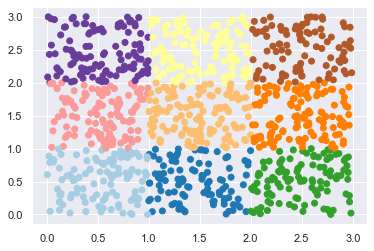

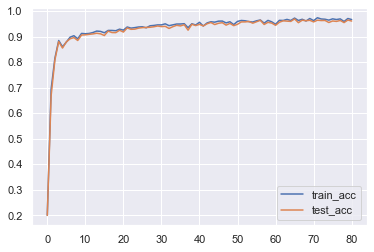

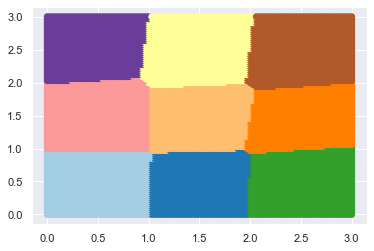

In [262]:
net = LR(9)
experiment(net, num_epoch=80)

Before training, train acc: 0.108, test acc: 0.111
epoch 5, train acc: 0.383, test acc: 0.402, time: 0.580
epoch 10, train acc: 0.431, test acc: 0.455, time: 0.571
epoch 15, train acc: 0.421, test acc: 0.442, time: 0.581
epoch 20, train acc: 0.402, test acc: 0.420, time: 0.708
epoch 25, train acc: 0.421, test acc: 0.443, time: 0.576


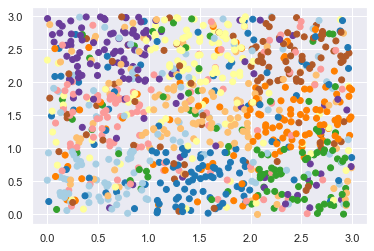

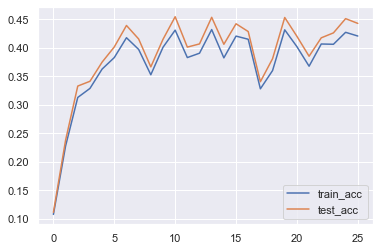

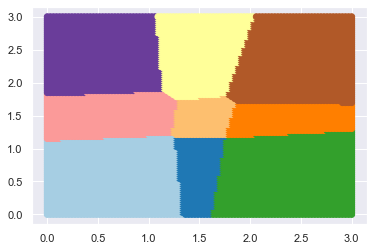

In [273]:
net = LR(9)
experiment(net, lr=0.01, disturb = 0.5, wd=0.001, num_epoch=25)

Before training, train acc: 0.181, test acc: 0.198
epoch 5, train acc: 0.496, test acc: 0.510, time: 2.906
epoch 10, train acc: 0.508, test acc: 0.514, time: 2.949
epoch 15, train acc: 0.526, test acc: 0.533, time: 2.847
epoch 20, train acc: 0.526, test acc: 0.532, time: 3.089
epoch 25, train acc: 0.526, test acc: 0.532, time: 3.005


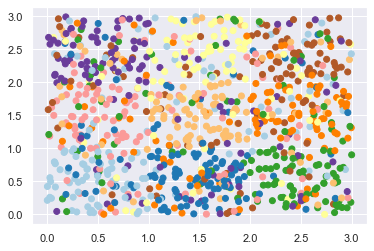

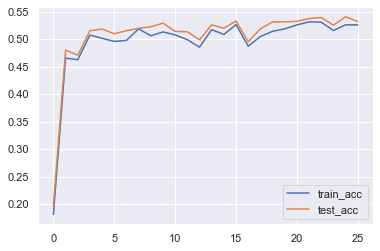

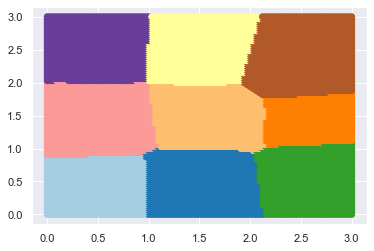

In [275]:
net = DNN(9)
experiment(net, lr=0.01, disturb = 0.5, wd=0.001, num_epoch=25)

Before training, train acc: 0.067, test acc: 0.067
epoch 5, train acc: 0.233, test acc: 0.033, time: 0.024
epoch 10, train acc: 0.250, test acc: 0.067, time: 0.025
epoch 15, train acc: 0.300, test acc: 0.067, time: 0.023
epoch 20, train acc: 0.350, test acc: 0.100, time: 0.023
epoch 25, train acc: 0.383, test acc: 0.100, time: 0.026


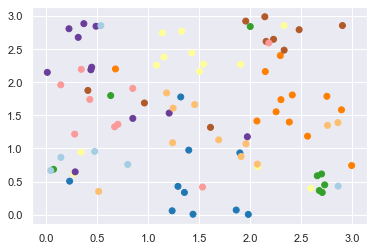

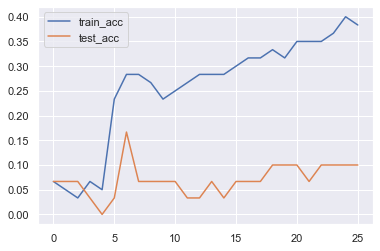

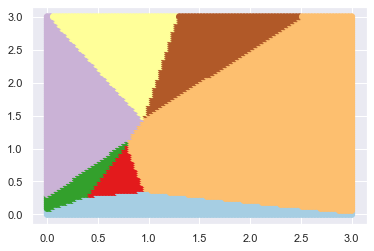

In [274]:
net = LR(9)
experiment(net, data_size=90, sampling_size=90,n_train=60, batch_size=9, lr=0.01, disturb = 0.5, wd=0.001, num_epoch=25)

In [219]:
X,Y = generate_data(size=90, disturb_prob=0.5)
data = shuffle_data(X,Y)
n_train = 60
X_train = data[:n_train, 0:2]
Y_train = data[:n_train, 2]
X_test = data[n_train:, 0:2]
Y_test = data[n_train:, 2]
batch_size = 30
train_set = gdata.ArrayDataset(X_train, Y_train)
test_set = gdata.ArrayDataset(X_test, Y_test)
train_iter = gdata.DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_iter = gdata.DataLoader(test_set, batch_size=batch_size)

Before training, train acc: 0.083, test acc: 0.067
epoch 5, train acc: 0.300, test acc: 0.200, time: 0.008
epoch 10, train acc: 0.367, test acc: 0.267, time: 0.008
epoch 15, train acc: 0.400, test acc: 0.267, time: 0.005
epoch 20, train acc: 0.400, test acc: 0.300, time: 0.006
epoch 25, train acc: 0.383, test acc: 0.267, time: 0.005
epoch 30, train acc: 0.400, test acc: 0.300, time: 0.007
epoch 35, train acc: 0.400, test acc: 0.300, time: 0.005
epoch 40, train acc: 0.417, test acc: 0.300, time: 0.005
epoch 45, train acc: 0.400, test acc: 0.333, time: 0.005
epoch 50, train acc: 0.417, test acc: 0.300, time: 0.005
epoch 55, train acc: 0.433, test acc: 0.267, time: 0.005
epoch 60, train acc: 0.417, test acc: 0.267, time: 0.005
epoch 65, train acc: 0.400, test acc: 0.200, time: 0.005
epoch 70, train acc: 0.433, test acc: 0.267, time: 0.005
epoch 75, train acc: 0.417, test acc: 0.267, time: 0.005
epoch 80, train acc: 0.417, test acc: 0.233, time: 0.005


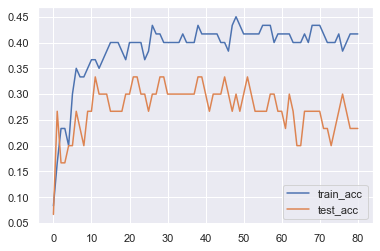

In [220]:
net = LR(9)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 0.1, 0, 80
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)

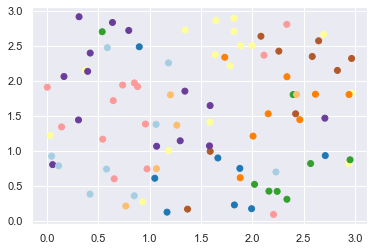

In [222]:
plt.scatter(X[:,0], X[:,1], c=Y,cmap=cm.Paired)
plt.show()

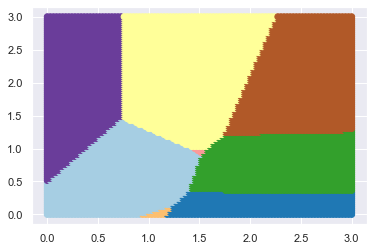

In [223]:
plot_decision_boundary(net)

Before training, train acc: 0.050, test acc: 0.067
epoch 5, train acc: 0.317, test acc: 0.233, time: 0.009
epoch 10, train acc: 0.433, test acc: 0.267, time: 0.008
epoch 15, train acc: 0.450, test acc: 0.267, time: 0.008
epoch 20, train acc: 0.517, test acc: 0.267, time: 0.011
epoch 25, train acc: 0.533, test acc: 0.333, time: 0.010
epoch 30, train acc: 0.533, test acc: 0.267, time: 0.008
epoch 35, train acc: 0.567, test acc: 0.233, time: 0.008
epoch 40, train acc: 0.567, test acc: 0.267, time: 0.009
epoch 45, train acc: 0.600, test acc: 0.267, time: 0.013
epoch 50, train acc: 0.617, test acc: 0.200, time: 0.008
epoch 55, train acc: 0.683, test acc: 0.200, time: 0.008
epoch 60, train acc: 0.683, test acc: 0.200, time: 0.009
epoch 65, train acc: 0.650, test acc: 0.233, time: 0.026
epoch 70, train acc: 0.650, test acc: 0.200, time: 0.028
epoch 75, train acc: 0.717, test acc: 0.233, time: 0.021
epoch 80, train acc: 0.783, test acc: 0.233, time: 0.011
epoch 85, train acc: 0.767, test acc: 

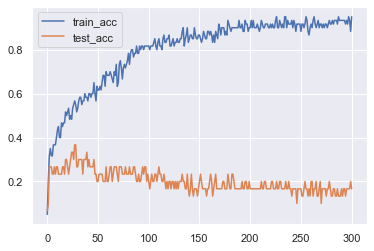

In [236]:
net = get_net(9)
loss = gloss.SoftmaxCrossEntropyLoss()
lr, wd, num_epoch = 0.01, 0, 300
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': lr, 'wd': wd})
train_acc, test_acc = train(net, train_iter, test_iter, trainer, loss, num_epoch)

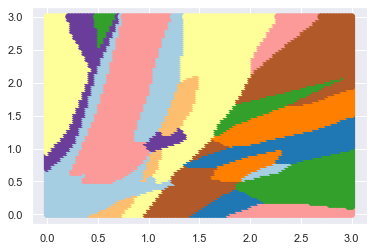

In [237]:
plot_decision_boundary(net)